### Assignment 3 : Reinforcement Learning Programming

Khushbu Nileshkumar Lad <br/>
9027375

### **Prerequisits**

#### Installation

In [1]:
pip install gym[atari] torch torchvision numpy==1.23.5 matplotlib gym[accept-rom-license] gymnasium ale-py opencv-python torchvision tqdm

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
    --------------------------------------- 0.3/14.6 MB ? eta -:--:--
   - -------------------------------------- 0.5/14.6 MB 1.1 MB/s eta 0:00:13
   -- ------------------------------------- 0.8/14.6 MB 958.5 kB/s eta 0:00:15
   -- ------------------------------------- 0.8/14.6 MB 958.5 kB/s eta 0:00:15
   -- ------------------------------------- 1.0/14.6 MB 786.4 kB/s eta 0:00:18
   -- ------------------------------------- 1.0/14.6 MB 786.4 kB/s eta 0:00:18
   -- ------------------------------------- 1.0/14.6 MB 786.4 kB/s 

DEPRECATION: Loading egg at c:\users\khushbu.lad\appdata\local\programs\python\python311\lib\site-packages\cloudpickle-3.1.1-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\khushbu.lad\appdata\local\programs\python\python311\lib\site-packages\gym-0.26.2-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\khushbu.lad\appdata\local\programs\python\python311\lib\site-packages\gym_maze-0.4-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\


   ----------------- --------------------- 93.8/204.2 MB 996.7 kB/s eta 0:01:51
   ----------------- --------------------- 94.1/204.2 MB 993.1 kB/s eta 0:01:51
   ------------------ -------------------- 94.4/204.2 MB 991.0 kB/s eta 0:01:51
   ------------------ -------------------- 94.4/204.2 MB 991.0 kB/s eta 0:01:51
   ------------------ -------------------- 94.6/204.2 MB 983.3 kB/s eta 0:01:52
   ------------------ -------------------- 94.9/204.2 MB 986.9 kB/s eta 0:01:51
   ------------------ -------------------- 95.2/204.2 MB 986.9 kB/s eta 0:01:51
   ------------------ -------------------- 95.4/204.2 MB 990.0 kB/s eta 0:01:50
   ------------------ -------------------- 95.7/204.2 MB 993.1 kB/s eta 0:01:50
   ------------------ -------------------- 95.9/204.2 MB 994.1 kB/s eta 0:01:49
   ------------------ -------------------- 96.2/204.2 MB 996.1 kB/s eta 0:01:49
   ------------------ -------------------- 96.5/204.2 MB 992.6 kB/s eta 0:01:49
   ------------------ -----------------

#### Import required libraries

In [2]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
import cv2
!ale-import-roms

'ale-import-roms' is not recognized as an internal or external command,
operable program or batch file.


#### Utils

In [3]:
# This is specific to the pong environment
def img_crop(img):
    # Check if the image is grayscale (2D) or color (3D)
    if img.ndim == 2:
        return img[30:-12, :]  # If grayscale, only slice height and width
    else:
        return img[30:-12, :, :]  # If color (RGB), slice as before

# GENERAL Atari preprocessing steps
def downsample(img):
    # We will take only half of the image resolution
    return cv2.resize(img, (80, 84), interpolation=cv2.INTER_AREA)

def transform_reward(reward):
    return np.sign(reward)

def to_grayscale(img):
    # Check if the image is already grayscale
    if img.ndim == 2:
        return img  # If already grayscale, return as is
    else:
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # If color, convert to grayscale

# Normalize grayscale image from -1 to 1.
def normalize_grayscale(img):
    # return (img - 128) / 128 - 1
    return img.astype(np.float32) / 128 - 1

def process_frame(img):
    img = img_crop(img)
    img = downsample(img)    # Crop and downsize (by 2)
    img = to_grayscale(img)       # Convert to greyscale by averaging the RGB values
    img = normalize_grayscale(img)  # Normalize from -1 to 1.

    return img;

### Initialise gym environment

In [4]:
env = gym.make('PongDeterministic-v4', render_mode="rgb_array")
print("Environment Loaded.")
print("Actions : ")
print(env.action_space.n)

Environment Loaded.
Actions : 
6


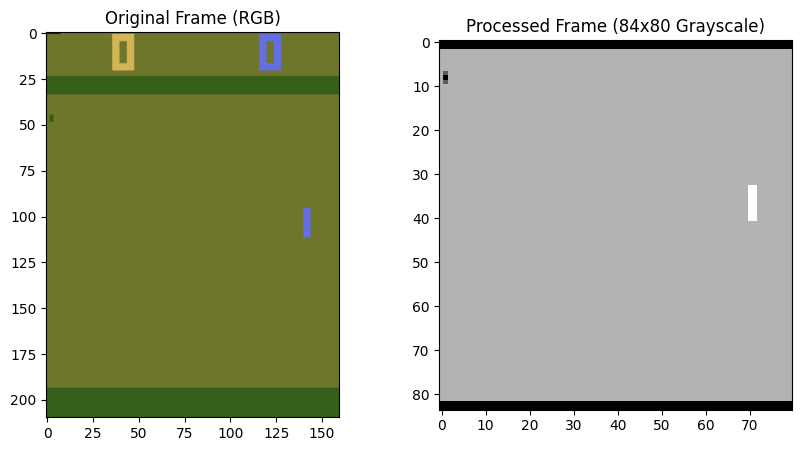

In [5]:
# Validate frame preprocess

# Reset environment and get first frame
state = env.reset()[0]
processed_frame = process_frame(state)

# Show original vs. processed frame
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(state)  # Original RGB image
axes[0].set_title("Original Frame (RGB)")
axes[1].imshow(processed_frame, cmap="gray")  # Grayscale processed image
axes[1].set_title("Processed Frame (84x80 Grayscale)")
plt.show()

### Preprocess the Observations

In [6]:
def stack_frames(stacked_frames, frame, is_new_episode):
    frame = process_frame(frame)

    if is_new_episode:
        stacked_frames = deque([frame] * 4, maxlen=4)
    else:
        stacked_frames.append(frame)

    stacked_state = np.stack(stacked_frames, axis=0)
    return stacked_state, stacked_frames

###  Define the DQN Architecture

In [7]:
class DQNetwork(nn.Module):
    def __init__(self, action_size):
        super(DQNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        # self.fc1 = nn.Linear(in_features=7*7*64, out_features=512)
        # self.out = nn.Linear(in_features=512, out_features=action_size)
        # Calculate the correct input size for fc1 dynamically
        self.fc1 = nn.Linear(in_features=self._get_conv_output_size(), out_features=512)
        self.out = nn.Linear(in_features=512, out_features=action_size)

    def _get_conv_output_size(self):
        # Create a dummy input tensor with the expected shape
        input = torch.zeros(1, 4, 84, 80) # Assuming input is 4 frames, 84x80
        # Pass the dummy input through the convolutional layers
        output = self.conv1(input)
        output = self.conv2(output)
        output = self.conv3(output)
        # Flatten the output and return the size
        return output.view(1, -1).size(1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.out(x)

action_size = env.action_space.n
dqn = DQNetwork(action_size)

### Implement the DQN Algorithm

####  Experience Replay

In [48]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = []
        self.capacity = capacity

    def add(self, experience):
        """ Adds experience to the buffer """
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)  # Remove oldest experience to maintain size
        self.buffer.append(experience)

    def sample(self, batch_size):
        """ Returns a random sample of batch_size experiences """
        return random.sample(self.buffer, batch_size)  # ✅ Correctly samples batch_size items

    def __len__(self):
        """ Returns the current size of the buffer """
        return len(self.buffer)



# buffer_size = 10000
# batch_size = 8
# replay_buffer = ReplayBuffer(buffer_size, batch_size)

#### Target Network

In [49]:
target_dqn = DQNetwork(action_size)
target_dqn.load_state_dict(dqn.state_dict())
target_dqn.eval()  


def update_target_network():
    target_dqn.load_state_dict(dqn.state_dict())  
    target_dqn.eval()

#### Training Loop

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

def train_dqn(episodes, gamma, epsilon, epsilon_decay, epsilon_min, update_rate, batch_size):
    dqn.train() 
    optimizer = optim.Adam(dqn.parameters(), lr=0.0001)
    loss_fn = nn.MSELoss()

    scores = []
    epsilon_values = []
    avg_cumulative_rewards = []

    for episode in range(episodes):
        state = env.reset()[0]  # Reset the environment
        state, stacked_frames = stack_frames(None, state, True)
        state = torch.FloatTensor(state).unsqueeze(0)  # Convert to tensor (add batch dimension)
        total_reward = 0
        done = False

        while not done:
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    q_values = dqn(state)
                    action = torch.argmax(q_values).item()

            # Step environment
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward

            next_state, stacked_frames = stack_frames(stacked_frames, next_state, False) 
            next_state = torch.FloatTensor(next_state).unsqueeze(0)  

            replay_buffer.add((state, action, reward, next_state, done))
            state = next_state

            # Training step
            if len(replay_buffer) >= batch_size:
                batch = replay_buffer.sample(batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)

                states = torch.stack(states)  # ✅ Fix: Properly stack tensors
                actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)  # ✅ Fix: Ensure int type
                rewards = torch.tensor(rewards, dtype=torch.float32)
                next_states = torch.stack(next_states)
                dones = torch.tensor(dones, dtype=torch.float32)

                # Compute Q-values
                q_values = dqn(states).gather(1, actions)  # Q(s, a)
                next_q_values = target_dqn(next_states).max(1)[0].detach()  # ✅ Fix: Detach gradients
                target_q_values = rewards + (gamma * next_q_values * (1 - dones))  # Bellman equation

                # Compute loss and optimize
                loss = loss_fn(q_values, target_q_values.unsqueeze(1))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Store rewards and update epsilon
        scores.append(total_reward)
        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        epsilon_values.append(epsilon)

        # Compute last 5 episodes' average cumulative reward
        avg_reward = np.mean(scores[-5:]) if len(scores) >= 5 else np.mean(scores)
        avg_cumulative_rewards.append(avg_reward)

        # Update target network periodically
        if episode % update_rate == 0:
            update_target_network()

        # Logging every 10 episodes
        if episode % 10 == 0:
            print(f"Episode {episode}, Score: {total_reward}, Avg Reward (last 5): {avg_reward:.2f}, Epsilon: {epsilon:.4f}")

    return scores, avg_cumulative_rewards, epsilon_values


### Train Agent

In [52]:
# Hyperparameters
episodes = 20
gamma = 0.95
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.05
update_rate = 10

batch_sizes = [8, 16]

# Run training for each batch size and unpack results properly
batch_results1 = [
    train_dqn(episodes=episodes, gamma=gamma, epsilon=epsilon, 
              epsilon_decay=epsilon_decay, epsilon_min=epsilon_min, 
              update_rate=update_rate, batch_size=bs)
    for bs in batch_sizes
]

# Unpack the list of tuples into separate variables
scores_batch1, avg_rewards_batch1, epsilon_values_batch1 = zip(*batch_results1)


TypeError: ReplayBuffer.sample() takes 1 positional argument but 2 were given

In [19]:
# Hyperparameters
episodes = 20
gamma = 0.95
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.05
update_rate = 10

# Train the DQN
# scores2, epsilon_values2 = train_dqn(episodes, gamma, epsilon, epsilon_decay, epsilon_min, update_rate)
batch_sizes = [8, 16]
batch_results2 = [train_dqn(episodes=episodes, gamma=gamma, epsilon=epsilon, epsilon_decay=epsilon_decay, epsilon_min=epsilon_min, update_rate=update_rate, batch_size=bs) for bs in batch_sizes]


TypeError: ReplayBuffer.sample() takes 1 positional argument but 2 were given

### Plot Metrices

In [45]:

def plot_results(results, param_name, param_values):
    plt.figure(figsize=(12, 5))

    for i, res in enumerate(results):
        plt.plot(res[0], label=f'{param_name} = {param_values[i]}')

    plt.xlabel('Episodes')
    plt.ylabel('Score per Episode')
    plt.title(f'Effect of {param_name} on DQN Training')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 5))
    for i, res in enumerate(results):
        plt.plot(res[1], label=f'{param_name} = {param_values[i]}')

    plt.xlabel('Episodes')
    plt.ylabel('Avg Cumulative Reward (Last 5)')
    plt.title(f'Effect of {param_name} on DQN Training')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 5))
    for i, res in enumerate(results):
        plt.plot(res[2], label=f'{param_name} = {param_values[i]}')

    plt.xlabel('Episodes')
    plt.ylabel('Steps per Episode')
    plt.title(f'Effect of {param_name} on DQN Training')
    plt.legend()
    plt.show()

plot_results(batch_results1, "Batch Size", batch_sizes)
plot_results(batch_results2, "Batch Size", batch_sizes)


NameError: name 'batch_results1' is not defined